Load control detection using power and power quality measurement data
---------------------------------------------------------------------

In [1]:
import pandas as pd
import numpy as np

from datetime import datetime

In [68]:
# In our study, there are two experiments: for the ventilation system and for the main distribution board
# Here we initialize a variable "exp_name", which is used to define a path to the measurement data

exp_name = 'main_distribution_board_2018_2020' # or exp_name = 'ventilation_system_2018_2020'

In [69]:
# Read measurement data from the csv-files
df_19_20 = pd.read_csv('{}/measurement_data_2019_2020.csv'.format(exp_name))
df_20_21 = pd.read_csv('{}/measurement_data_2020_2021.csv'.format(exp_name))

In [70]:
#Select input variables for different experiments, e.g.,

selected_variables = ['date', 'TDUL1', 'TDUL2', 'TDUL3',
                      'ITDL1', 'ITDL2', 'ITDL3',
                      'Q1actL1', 'Q1actL2', 'Q1actL3',
                      'PL1', 'PL2', 'PL3'
                     ] # power + power quality

In [71]:
# Create a column "date" for further transformations
df_19_20['date'] = pd.DatetimeIndex(df_19_20.Timestamp).date
df_20_21['date'] = pd.DatetimeIndex(df_20_21.Timestamp).date

In [72]:
# Data Transformation: 
# create daily values from 10-min PQ-inputs using mean, max, min, and std 
def create_daily_values(df):
    
    df_mean = df.groupby(['date']).mean()
    df_mean.columns = [col+'_mean' for col in df_mean.columns]

    df_max = df.groupby(['date']).max()
    df_max.columns = [col+'_max' for col in df_max.columns]

    df_min = df.groupby(['date']).min()
    df_min.columns = [col+'_min' for col in df_min.columns]

    df_std = df.groupby(['date']).std()
    df_std.columns = [col+'_std' for col in df_std.columns]

    df_all = df_mean.copy()
    df_all = df_all.join(df_max)
    df_all = df_all.join(df_min)
    df_all = df_all.join(df_std)
    
    return df_all

df_daily_2019_2020 = create_daily_values(df_19_20.loc[:, selected_variables])
df_daily_2020_2021 = create_daily_values(df_20_21.loc[:, selected_variables])

In [74]:
# Add an outcome variable "control"
df_daily_2019_2020['control'] = 0
df_daily_2020_2021['control'] = 1

Supervised learning
-------------------

In [162]:
# Days from Dec 2019 and Dec 2020 are used as the test data
test_data = pd.concat( [df_daily_2019_2020.loc[pd.DatetimeIndex(df_daily_2019_2020.index).month == 12],
                        df_daily_2020_2021.loc[pd.DatetimeIndex(df_daily_2020_2021.index).month == 12]
                       ] )

# Days from Nov, Jan, Feb 2019-2020 and Nov, Jan, Feb 2020-2021 are used as the training data
training_data = pd.concat( [df_daily_2019_2020.loc[pd.DatetimeIndex(df_daily_2019_2020.index).month != 12],
                            df_daily_2020_2021.loc[pd.DatetimeIndex(df_daily_2020_2021.index).month != 12]
                           ] )


In [163]:
# There was one day in Dec 2020 (2020-12-27), when load contol was off
test_data.iloc[57, len(test_data.columns)-1] = 0

In [165]:
# imports for supervised learning
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score

In [166]:
# Drop data lines with missing values, if there are any
training_data_noNan = training_data.dropna()
test_data_noNan = test_data.dropna()

In [86]:
# Train and test Random Forest; examine the model performance in multiple runs 
training_inputs = training_data_noNan.loc[:, training_data_noNan.columns[:-1]]
training_output = training_data_noNan.control.values

test_inputs = test_data_noNan.loc[:, test_data_noNan.columns[:-1]]
test_output = test_data_noNan.control.values

rf_results = pd.DataFrame(columns = ['run', 'depth', 'train_acc', 'valid_acc', 'test_acc'])

runs = 25
# Tune the max tree depth on the validation data
depths = [1,2,3,4,5,7,10,13,15,18,20,22,25]

for depth in depths:
    for run in range(runs):
                
        acc_train = 0
        acc_valid = 0
        acc_test = 0
        
        model = RandomForestClassifier(max_depth = depth, n_estimators = 100)

        # Validation
        n_splits = 5
        cv = StratifiedShuffleSplit(n_splits=n_splits)
        for train_index, valid_index in cv.split(training_inputs, training_output):

            train_x = training_inputs.iloc[train_index]
            train_y = training_output[train_index]

            valid_x = training_inputs.iloc[valid_index]
            valid_y = training_output[valid_index]

            model.fit(train_x, train_y.ravel())
            predictions_valid = model.predict(valid_x)
            acc_valid = acc_valid + accuracy_score(valid_y, predictions_valid)/n_splits

        # Training
        model.fit(training_inputs, training_output)
        predictions_train = model.predict(training_inputs)
        acc_train = accuracy_score(training_output, predictions_train)
        
        # Testing
        predictions_test = model.predict(test_inputs)
        acc_test = accuracy_score(test_output, predictions_test)
        
        rf_results = rf_results.append({'run': run, 'depth': depth, 
                                        'train_acc': acc_train, 'valid_acc': acc_valid, 'test_acc': acc_test}, ignore_index = True)

In [88]:
# Find the best "max tree depth" values based on the validation performance
depth_opt = rf_results.groupby(['depth']).mean().index[rf_results.groupby(['depth']).mean()['valid_acc'].argmax()]

In [ ]:
# Test performance in multiple runs
test_accuracy = rf_results.loc[rf_results.loc[:, 'depth'] == depth_opt, 'test_acc'].values
print("Average test performance: {}".format(sum(test_accuracy)/len(test_accuracy)))

In [166]:
# Train Random Forest with the optimized "max tree depth" multiple times to analyze variable importances
training_inputs = training_data_noNan.loc[:, training_data_noNan.columns[:-1]]
training_output = training_data_noNan.control.values

test_inputs = test_data_noNan.loc[:, test_data_noNan.columns[:-1]]
test_output = test_data_noNan.control.values

runs = 100
    
rf_predictions = pd.DataFrame(columns = ['predictions_{}'.format(run) for run in range(runs)], index = test_inputs.index)
rf_importance = pd.DataFrame(columns = ['importance_{}'.format(run) for run in range(runs)], index = test_inputs.columns)


for run in range(runs):

    model = RandomForestClassifier(max_depth = dept_opt, n_estimators = 100)

    # Training
    model.fit(training_inputs, training_output)
    predictions_train = model.predict(training_inputs)

    # Testing
    predictions_test = model.predict(test_inputs)
    
    rf_predictions.loc[:, 'predictions_{}'.format(run)] = predictions_test
    rf_importance.loc[:, 'importance_{}'.format(run)] = model.feature_importances_


In [167]:
# Importance
top_10 = (rf_importance.sum(axis = 1)/runs).to_frame(name = 'importance').sort_values('importance', ascending = False).head(10)

Unsupervised learning
---------------------

In [77]:
# In the unsupervised scenario, days from Dec 2020 are used to test the model;
# days from Dec 2019 are used to validate the model;
# days from Nov, Jan, Feb 2019-2020 are used to train the model

test_data = pd.concat( [df_daily_2020_2021.loc[pd.DatetimeIndex(df_daily_2020_2021.index).month == 12]
                     ] )

validation_data = pd.concat( [df_daily_2019_2020.loc[pd.DatetimeIndex(df_daily_2019_2020.index).month == 12]
                           ] )

training_data = pd.concat( [df_daily_2019_2020.loc[pd.DatetimeIndex(df_daily_2019_2020.index).month != 12]
                           ] )


In [78]:
# There was one day in Dec 2020 (2020-12-27), when load contol was off
test_data.iloc[26, len(test_data.columns)-1] = 0

In [79]:
# Drop data lines with missing values; separate inputs and outputs
training_data_noNan = training_data.dropna()
validation_data_noNan = validation_data.dropna()
test_data_noNan = test_data.dropna()

training_inputs = training_data_noNan.loc[:, training_data_noNan.columns[:-1]]
training_output = training_data_noNan.control.values

validation_inputs = validation_data_noNan.loc[:, validation_data_noNan.columns[:-1]]
validation_output = validation_data_noNan.control.values

test_inputs = test_data_noNan.loc[:, test_data_noNan.columns[:-1]]
test_output = test_data_noNan.control.values


In [80]:
# Preselect inputs if needed (we keep all the variables)
columns_selected = training_inputs.columns

In [81]:
# Train the Isolation Forest model that returns anomality scores (in several independent runs)
# Use the validation data to adjust the threshold (i.e., 'percentile')
# Estimate anomality scores for the test data; return the final binary predictions (anomality or not, i.e., control or not)

from sklearn.ensemble import IsolationForest

df = pd.DataFrame(columns = ['run', 'percentile', 'acc_test', 'acc_valid'])

training_scores = np.zeros(training_inputs.shape[0])
validation_scores = np.zeros(validation_inputs.shape[0])
test_scores = np.zeros(test_inputs.shape[0])

runs = 25

for r in range(runs):
    clf = IsolationForest().fit(training_inputs.loc[:, columns_selected])
    
    training_scores = training_scores + clf.score_samples(training_inputs.loc[:, columns_selected])/runs
    validation_scores = validation_scores + clf.score_samples(validation_inputs.loc[:, columns_selected])/runs
    test_scores = test_scores + clf.score_samples(test_inputs.loc[:, columns_selected])/runs
        
for percentile in [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]:
    threshold = np.percentile(training_scores, percentile)

    predictions_validation = [1 if score<threshold else 0 for score in validation_scores]
    error_valid = np.abs(predictions_validation - validation_output).sum()/len(predictions_validation)

    predictions_test = [1 if score<threshold else 0 for score in test_scores]
    error_test = np.abs(predictions_test - test_output).sum()/len(predictions_test)

    df = df.append({'run': r, 'percentile': percentile, 'acc_test': 1.-error_test, 'acc_valid': 1.-error_valid}, ignore_index = True)

In [82]:
# Define the threshold as the maximum percentile value that leads to 100%-accuracy on the validation data
# There are several very low anomality scores for the training data; 
# if there are outliers in the training data, this strategy helps deal with them

percentile = df_average.loc[max(list(df_average.index[(df_average.loc[:, "acc_valid"] == 1.0)])), "percentile"]
threshold_opt = np.percentile(training_scores, percentile)
df_average = df.groupby(['percentile']).mean()
df_average = df_average.drop('run', axis = 1).reset_index()

In [ ]:
# Average test performance
test_accuracy = df_average.loc[ df_average.loc[:, 'percentile'] == percentile, 'test_acc' ]

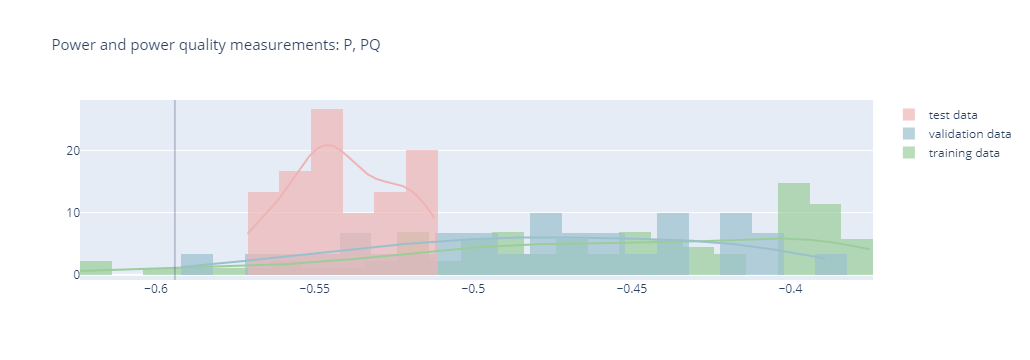

In [87]:
# Visualize distributions of anomality scores for the training, validation, and test data

import plotly.figure_factory as ff
import plotly.graph_objects as go
import plotly.express as px
import numpy as np

hist_data = [training_scores, validation_scores, test_scores]
group_labels = ['training data', 'validation data', 'test data'] # name of the dataset

fig = ff.create_distplot(hist_data, group_labels, curve_type='kde', colors = ['RGB(155,205,155)', 'RGB(154,192,205)', 'RGB(238,180,180)'],
                         show_rug=False, bin_size = 0.01)

fig.update_layout(barmode='overlay', 
    title={'text':'Power and power quality measurements: P, PQ', 'font':{'size':15}})

fig.update_layout(shapes=[
    dict(
      type= 'line',
      yref= 'paper', y0= 0, y1= 1,
      xref= 'x', x0= threshold_opt, x1= threshold_opt,
      fillcolor = 'gray', opacity = 0.25
    )
])


fig.update_layout(height=350, width=900)

fig.show()